# Can Google Trends Data help us predict the fear index ?

In [1]:
from functools import reduce

import numpy as np
import pandas as pd
import yfinance as yf
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from pytrends import dailydata
from pytrends.request import TrendReq
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
%matplotlib inline
FONT_SIZE = 20
set_matplotlib_formats("svg")
plt.style.use("seaborn")
plt.rc("xtick", labelsize=14)
plt.rc("ytick", labelsize=14)

In [ ]:
# Helper functions for the ARIMA/VARMA/VAR models
import dask
from tqdm import tqdm

dask.config.set(scheduler="processes")

# dask delayed to parallel compute
@dask.delayed
def compute_ARIMA_endo_pred(df, order, index_insample, rolling_window):
    df_training = df.iloc[0:index_insample]
    outsample = df.iloc[index_insample]

    result_fit = ARIMA(endog=df_training["VIX"], order=order).fit()
    result_pred = result_fit.predict(
        start=len(df_training), end=len(df_training)
    ).values[0]
    return result_pred


@dask.delayed
def compute_ARIMA_exo_pred(
    df, order, exogenous_regressors, index_insample, rolling_window
):
    df_training = df.iloc[0:index_insample]
    outsample = df.iloc[index_insample]

    result_fit = ARIMA(
        endog=df_training["VIX"], order=order, exog=df_training[exogenous_regressors]
    ).fit()
    result_pred = result_fit.predict(
        start=len(df_training),
        end=len(df_training),
        exog=list(outsample[exogenous_regressors]),
    ).values[0]
    return result_pred


@dask.delayed
def compute_VAR_exo_pred(
    df, order, exogenous_regressors, index_insample, rolling_window
):
    df_training = df.iloc[0:index_insample]
    outsample = df.iloc[index_insample]
    try:
        result_fit = VAR(df_training).fit(order)
        result_pred = result_fit.forecast(y=df_training.values[-order:], steps=1)[0][0]
    except:
        result_pred = np.nan
    return result_pred


@dask.delayed
def compute_VARMA_exo_pred(
    df, order, exogenous_regressors, index_insample, rolling_window
):
    df_training = df.iloc[0:index_insample]
    outsample = df.iloc[index_insample]
    result_fit = VARMAX(df_training, order=order).fit(maxiter=1000, disp=False)
    result_pred = result_fit.predict(
        start=len(df_training), end=len(df_training)
    ).values[0][0]
    return result_pred


def rolling_ARMA_endo(df, start_window, rolling_window, order=(4, 0, 3)):
    result = []
    all_results_dask = [
        compute_ARIMA_endo_pred(df, order, index_insample, rolling_window)
        for index_insample in np.arange(start_window, len(df))
    ]
    all_results = dask.compute(all_results_dask)

    return all_results


def rolling_ARMA_exo(
    df, start_window, rolling_window, order=(4, 0, 3), exogenous_regressors=["crisis"]
):
    result = []
    all_results_dask = [
        compute_ARIMA_exo_pred(
            df, order, exogenous_regressors, index_insample, rolling_window
        )
        for index_insample in np.arange(start_window, len(df))
    ]
    all_results = dask.compute(all_results_dask)

    return all_results


def rolling_VAR_exo(
    df, start_window, rolling_window, order=4, exogenous_regressors=["crisis"]
):
    result = []
    all_results_dask = [
        compute_VAR_exo_pred(
            df, order, exogenous_regressors, index_insample, rolling_window
        )
        for index_insample in np.arange(start_window, len(df))
    ]
    all_results = dask.compute(all_results_dask)

    return all_results


def rolling_VARMA_exo(
    df, start_window, rolling_window, order=4, exogenous_regressors=["crisis"]
):
    result = []
    all_results_dask = [
        compute_VARMA_exo_pred(
            df, order, exogenous_regressors, index_insample, rolling_window
        )
        for index_insample in np.arange(start_window, len(df))
    ]
    all_results = dask.compute(all_results_dask)

    return all_results

## Loading Data and preprocessing
### Google trends
The VIX represents the fear index, hence it reacts to various factors linked to the economy. We chose reasonable google trends keywords.

In [3]:
# use capture magic to avoid pytrends from printing
#%%capture

# Loading google trends data daily
pytrends = TrendReq(hl="en-US", tz=360)

START_YEAR = 2019
START_MONTH = 1
END_YEAR = 2020
END_MONTH = 10

keywords = [
    "recession",
    "war",
    "stock market",
    "conflict",
    "terrorism",
    "mortgage",
    "bankrupcy",
    "debt",
    "elections",
    "economy",
    "protest",
    "shooting",
    "food bank",
    "loan",
    "virus",
    "crisis",
]

In [4]:
df_list = []
for keyword in keywords:
    df_tmp = dailydata.get_daily_data(
        keyword, START_YEAR, START_MONTH, END_YEAR, END_MONTH, geo="US"
    )
    df_list.append(df_tmp[keyword].to_frame())

df_merged = reduce(
    lambda left, right: pd.merge(left, right, on=["date"], how="outer"), df_list
)
df_merged.head()

In [5]:
df_merged = pd.read_csv("./df_merged.csv", parse_dates=["date"], index_col="date")
df_merged

,recession,war,stock market,conflict,terrorism,mortgage,bankrupcy,debt,elections,economy,protest,shooting,food bank,loan,virus,crisis
date,,,,,,,,,,,,,,,,
2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-27,4.62,31.5,13.4,36.58,26.52,30.03,26.46,51.1,48.00,43.12,2.00,12.88,26.86,47.30,1.60,29.12
2020-10-28,4.90,34.5,19.4,41.54,21.84,29.64,36.54,62.3,44.16,42.00,1.70,12.88,30.94,46.20,1.76,28.80
2020-10-29,4.55,32.5,19.0,43.40,22.62,33.15,21.00,53.9,38.88,48.72,1.48,9.52,34.00,51.15,1.76,28.80


## Plot degueulasse, on le garde ?

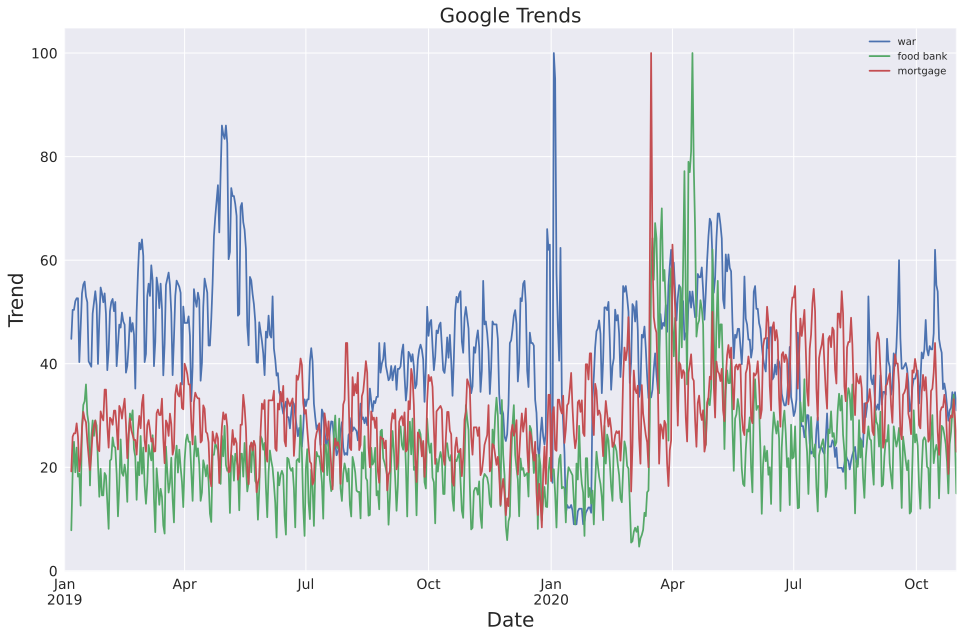

In [6]:
# let's just plot a few of them
axes = df_merged[["war", "food bank", "mortgage"]].plot(figsize=(16, 10))
_ = axes.set_xlabel("Date", fontsize=FONT_SIZE)
_ = axes.set_ylabel("Trend", fontsize=FONT_SIZE)
_ = axes.set_title("Google Trends", fontsize=FONT_SIZE)

In [7]:
# Loading daily VIX data from yahoo using the API
vix_obj = yf.Ticker("^VIX")
df_market = vix_obj.history(period="max")
df_market = df_market["Close"].to_frame()
df_market.rename(columns={"Close": "VIX"}, inplace=True)

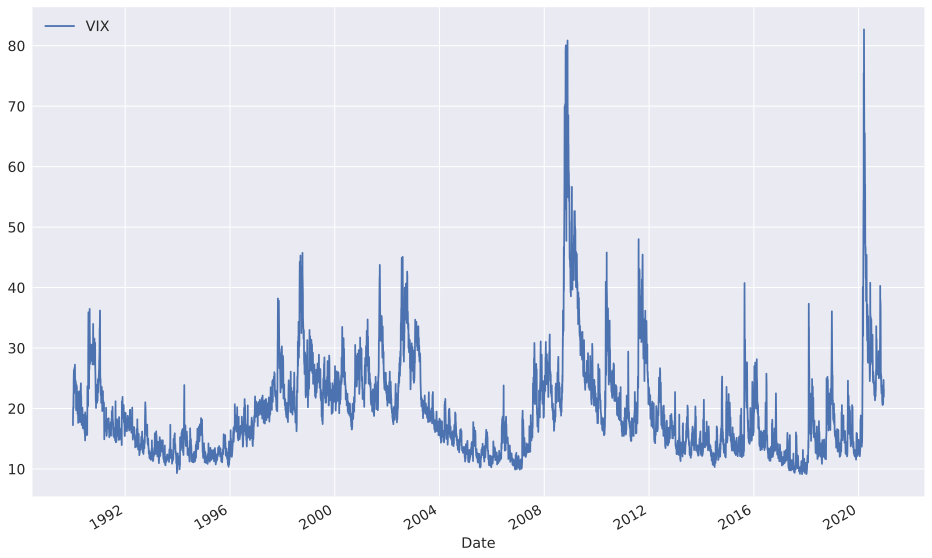

In [8]:
axes = df_market.plot(figsize=(16, 10))
_ = axes.set_xlabel("Date", fontsize="x-large")
_ = plt.legend(fontsize="x-large")

In [9]:
df_trends = df_merged

# Merging both dataframes
df_market = pd.merge(
    df_market, df_trends, how="left", left_index=True, right_index=True
)

# Processing data
df_market.dropna(inplace=True)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market[["VIX"] + keywords]
df_market.index = pd.to_datetime(df_market.index)
df_market.head()

,VIX,recession,war,stock market,conflict,terrorism,mortgage,bankrupcy,debt,elections,economy,protest,shooting,food bank,loan,virus,crisis
Date,,,,,,,,,,,,,,,,,
2019-01-07,21.400000,3.78,50.40,9.94,31.27,13.94,25.92,62.41,72.16,4.80,36.96,0.44,8.54,19.04,46.98,1.76,25.53
2019-01-08,20.469999,4.68,50.40,9.10,39.22,21.76,26.56,22.12,79.20,5.82,45.92,0.53,7.56,24.92,43.20,1.98,28.49
2019-01-09,19.980000,4.41,52.08,10.50,39.75,15.64,26.56,38.71,84.48,5.58,44.80,0.46,8.82,19.04,50.76,1.92,34.41
2019-01-10,19.500000,5.13,52.64,9.80,41.87,21.08,28.48,38.71,82.72,5.70,52.08,0.70,7.14,23.80,48.60,1.72,36.63
2019-01-11,18.190001,3.96,52.64,8.96,45.05,26.18,25.92,52.14,73.92,4.44,43.12,0.67,10.64,18.20,50.76,1.80,37.00


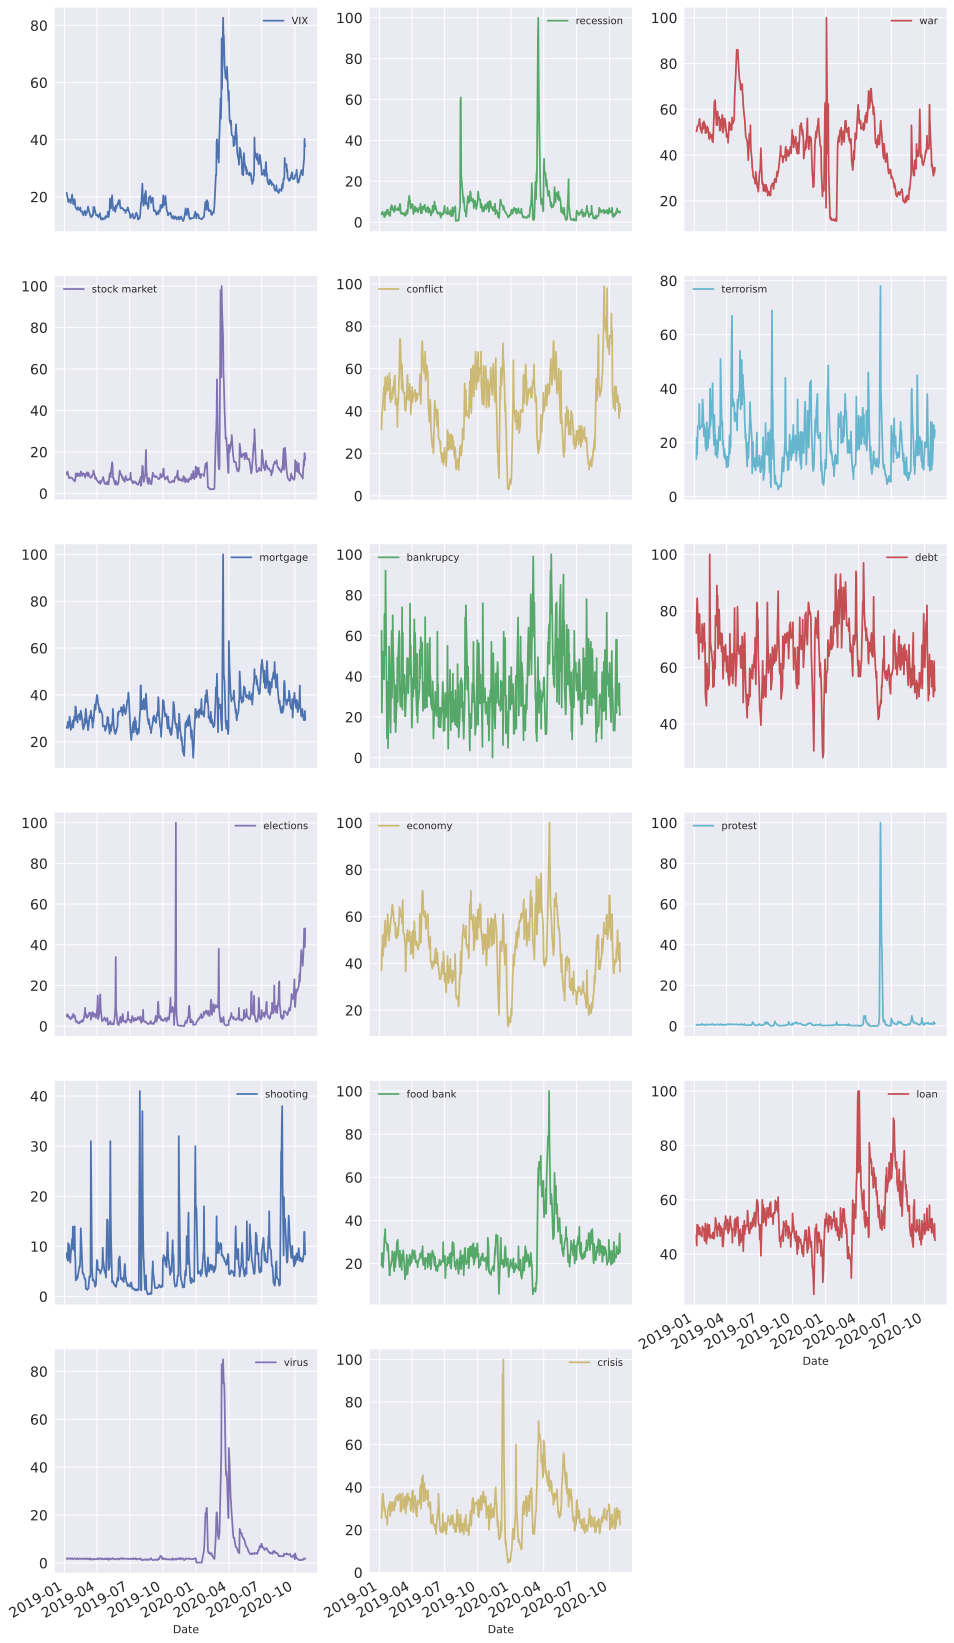

In [10]:
axs = df_market.plot(subplots=True, layout=(6, 3), figsize=(16, 32))

AS we can see above, daily VIX data contains a lot of noise due to trading. Hence it is hard to predict daily changes of the VIX. Furthermore daily google Trends data is also noisy since searches of keywords depend on various factors (workdays/weekends as markets are closed on the weekend). In order to mitigate this noise we are going to resample the data weekly.
For VIX we will be taking the last value of the week as we are interested in predicting the changes, and taking the weekly mean for trends data to reduce the noise

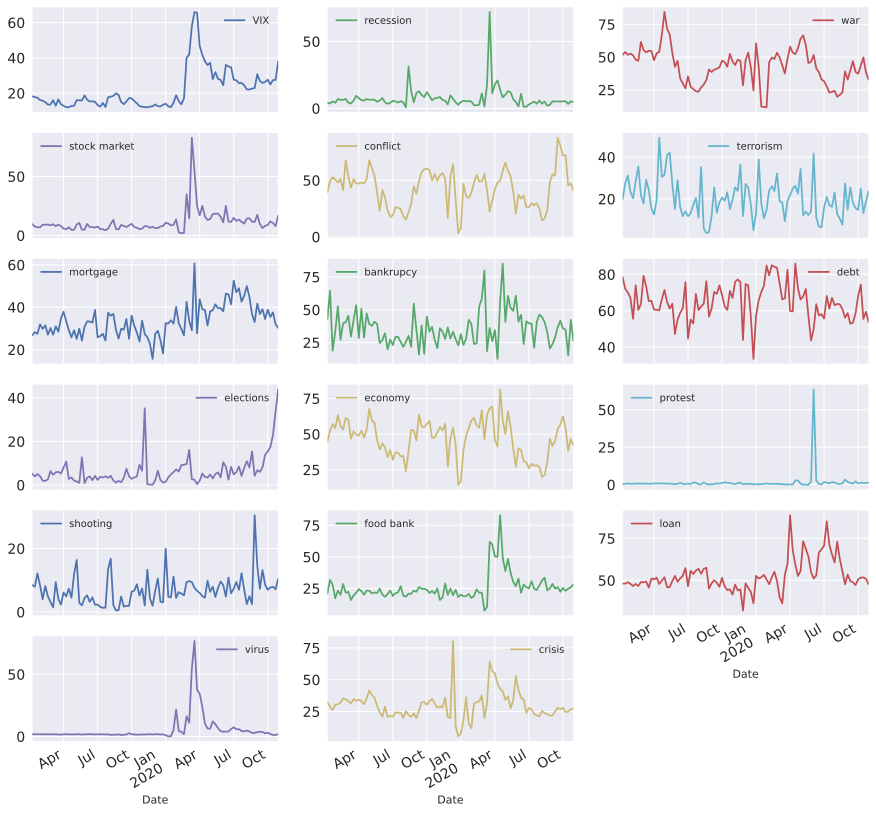

In [11]:
df_vix = df_market["VIX"].resample("1W").last().to_frame()
df_vix[keywords] = df_market[keywords].resample("1W").mean()
_ = df_vix.plot(subplots=True, layout=(6, 3), figsize=(15, 15))

To reduce the number of trends we are going to use in the models, we first going to select the trends that are correlated with the VIX. We are going to run a linear regression and check for statistical significance (pvalue<=0.05)

In [12]:
import statsmodels.api as sm

selected_keywords = []
for keyword in keywords:
    # adding intercept to the model
    X = sm.add_constant(df_vix[keyword])
    Y = df_vix["VIX"]
    result = sm.OLS(Y, X).fit()
    # getting pvalue of the regressor
    pvalue = result.pvalues[1]
    if pvalue <= 0.05:
        selected_keywords.append(keyword)

print(selected_keywords)
keywords = selected_keywords

['recession', 'stock market', 'mortgage', 'food bank', 'loan', 'virus', 'crisis']


In [13]:
df_vix = df_vix[["VIX"] + keywords]

The data is less noisy after resampling and to apply timeseries theory we have to check for stationarity. It is obvious that the timeseries are not stationary (tests below). We are going to calculate the difference and test the stationarity.

In [15]:
column_names = df_vix.columns
# realizing augmented Dickey-Fuller test for stationarity for all timeseries
ADF_pvalues = [
    adfuller(df_vix[column_name], regression="nc")[1] for column_name in column_names
]

# putting the p-values in a df for pretty printing
df_pvalues = pd.DataFrame(
    list(zip(column_names, ADF_pvalues)), columns=["Indicators", "pvalue"]
)
df_pvalues.round(4)

,Indicators,pvalue
0,VIX,0.5979
1,recession,0.0360
2,stock market,0.0268
3,mortgage,0.6034
4,food bank,0.5078
5,loan,0.5763
6,virus,0.0021
7,crisis,0.4426


In [16]:
# Making the timeseries stationary by log difference (most used by practionners)
df_vix = df_vix - df_vix.shift(1)
df_vix.dropna(inplace=True)

column_names = df_vix.columns
ADF_pvalues = [
    adfuller(df_vix[column_name], regression="nc")[1] for column_name in column_names
]
df_pvalues = pd.DataFrame(
    list(zip(column_names, ADF_pvalues)), columns=["Indicators", "pvalue"]
)
df_pvalues.round(5)

,Indicators,pvalue
0,VIX,0.00000
1,recession,0.00000
2,stock market,0.00000
3,mortgage,0.00000
4,food bank,0.00000
5,loan,0.00000
6,virus,0.00007
7,crisis,0.00000


The difference successfuly results to stationary timeseries as the pvalues are almost 0

## Overall model

### Baseline model

We will build the baseline model using only the VIX timeserie. Let us start by plot the autocorrelation and the partial autocorrelation

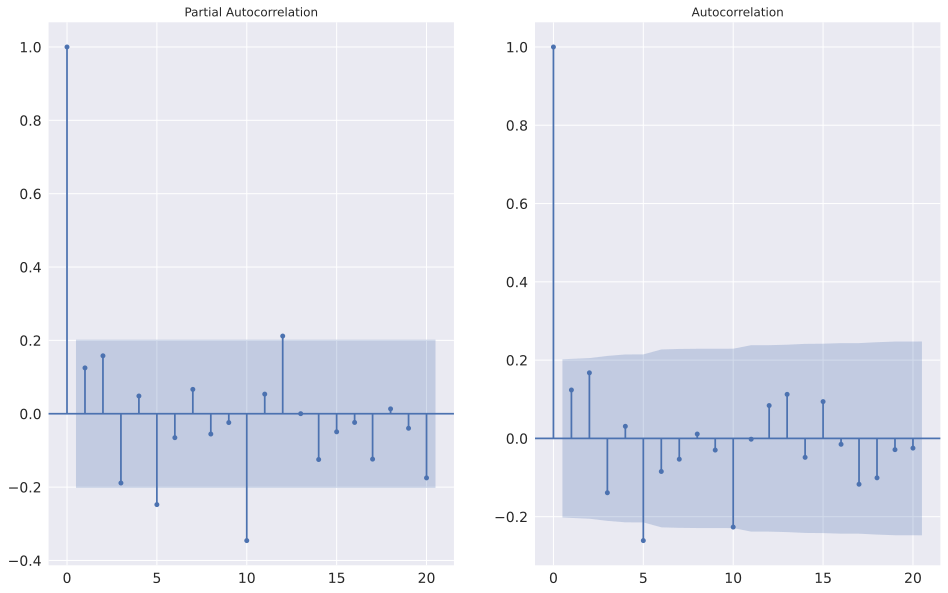

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 10))

# plot acf and pacf
plot_pacf(df_vix["VIX"], lags=20, ax=axs[0])
plot_acf(df_vix["VIX"], lags=20, ax=axs[1])
plt.show()

As we can see from the ACF and PACF, the correlations seems are not statistically significant as the confidence interval is large. Which is normal as we are calculating correlations around a crisis. Let us build an ARMA model using only VIX data to have a baseline to compare when adding Trends data.

In [18]:
from statsmodels.tsa.arima.model import ARIMA

model_arma_endo = ARIMA(endog=df_vix["VIX"], order=(2, 0, 2)).fit()
model_arma_endo.summary()

/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VIX   No. Observations:                   94
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -270.665
Date:                Fri, 18 Dec 2020   AIC                            553.330
Time:                        21:22:06   BIC                            568.590
Sample:                    01-20-2019   HQIC                           559.494
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2255      0.675      0.334      0.738      -1.098       1.549
ar.L1         -1.2116      0.219     -5.530      0.000      -1.641      -0.782
ar.L2         -0.4739      0.217     -2.186      0.029      -0.899      -0.049
ma.L1          1.3990      0.184      7.590      0.000       1.038       1.760
ma.L2          0.7802      0.174      4.488      0.000       0.439       1.121
sigma2        18.4302      1.902      9.691      0.000      14.703      22.158
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               210.45
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.53   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The ARMA(2,2) model shows statistical significance for the regressors. We chose this model after testing different parameters. It is the only one that shows significance for all the variables. Let visualize the insample predictions generated by this model to predict the VIX lof difference.

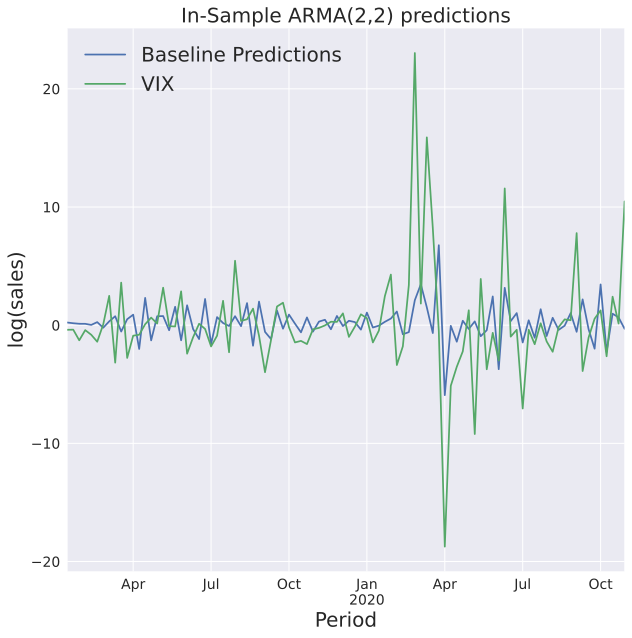

In [19]:
# insample prediction
predictions_endo = model_arma_endo.predict()
df_vix["Baseline Predictions"] = predictions_endo
axes = df_vix[["Baseline Predictions", "VIX"]].plot(figsize=(10, 10))
_ = axes.set_xlabel("Period", fontsize=FONT_SIZE)
_ = axes.set_ylabel("log(sales)", fontsize=FONT_SIZE)
_ = axes.set_title("In-Sample ARMA(2,2) predictions", fontsize=FONT_SIZE)
_ = axes.legend(fontsize=FONT_SIZE)

All predictions are insample and we can see that the model is struggling to predict big jumps. It is expected as VIX reacts brutally and considering past values will give us poor predictions.

Let us add Trends data using a multidimensional VAR model. Below using AIC or BIC we are going to select the order of the VAR model overall

### Trends models

#### VAR model

We will build an overall VAR model using trends data. To determine the order of the model we will use the AIC criterion.

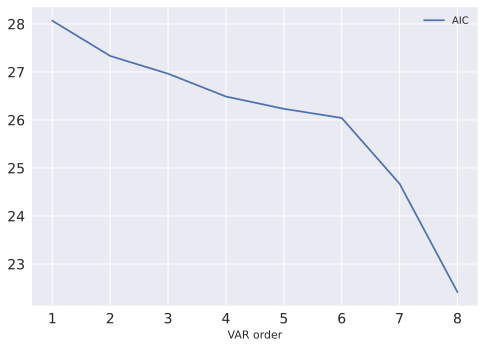

In [20]:
from statsmodels.tsa.api import VAR

model = VAR(df_vix[["VIX"] + keywords])
# Calculating AIC for different orders of VAR
VAR_orders = [1, 2, 3, 4, 5, 6, 7, 8]
aic_values = [model.fit(i).aic for i in VAR_orders]

# Grouping AIC results in a dataframe
df_aic_values = pd.DataFrame(
    list(zip(VAR_orders, aic_values)), columns=["VAR order", "AIC"]
)
df_aic_values.set_index("VAR order", inplace=True, drop=True)
_ = df_aic_values.plot()

In [21]:
df_vix

,VIX,recession,stock market,mortgage,food bank,loan,virus,crisis,Baseline Predictions
Date,,,,,,,,,
2019-01-20,-0.390001,-0.7920,-2.1200,1.5600,10.752,-0.042,-0.004,-3.512,0.225482
2019-01-27,-0.379999,1.5975,-0.5525,-0.7755,-3.702,0.852,-0.052,-2.580,0.164063
2019-02-03,-1.280001,-0.9575,-0.0515,4.4475,-10.824,-1.026,0.048,4.064,0.119558
2019-02-10,-0.419999,2.7440,2.1060,-2.1360,6.070,-1.230,-0.080,0.276,0.115277
2019-02-17,-0.810000,-0.6160,0.1100,1.6460,-3.370,1.230,0.024,1.308,0.022180
...,...,...,...,...,...,...,...,...,...
2020-10-04,1.250000,0.2380,0.8640,4.3680,3.064,3.426,0.456,1.246,3.445599
2020-10-11,-2.629999,-0.0280,2.9080,-3.3760,-2.260,1.004,-1.072,-3.248,-2.261006
2020-10-18,2.410000,-1.9060,-1.3080,2.1440,1.672,0.116,-0.698,-0.060,0.970364


In order to avoid overfitting we are going to choose the first minimum which is 3. Hence the Var order we are going to choose is 3

In [22]:
# generating summary of the chosen model
selected_VAR_order = 3
model = VAR(df_vix[["VIX"] + keywords])
result = model.fit(selected_VAR_order)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 18, Dec, 2020
Time:                     21:22:07
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    32.4817
Nobs:                     91.0000    HQIC:                   29.1896
Log likelihood:          -2059.82    FPE:                5.75877e+11
AIC:                      26.9633    Det(Omega_mle):     8.26033e+10
--------------------------------------------------------------------
Results for equation VIX
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.241530         0.408147            0.592           0.554
L1.VIX                 -0.036433         0.178106           -0.205           0.838
L1.recession           -0.034045         0.116869     

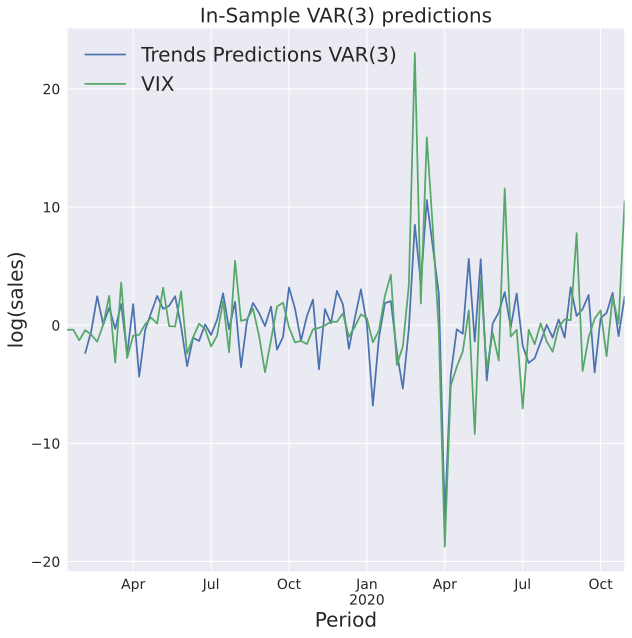

In [23]:
# Plotting the insample prediction of the VAR(3) model
predictions_exo = result.fittedvalues["VIX"]
df_vix["Trends Predictions VAR(3)"] = predictions_exo
axes = df_vix[["Trends Predictions VAR(3)", "VIX"]].plot(figsize=(10, 10))
_ = axes.set_xlabel("Period", fontsize=FONT_SIZE)
_ = axes.set_ylabel("log(sales)", fontsize=FONT_SIZE)
_ = axes.set_title("In-Sample VAR(3) predictions", fontsize=FONT_SIZE)
_ = axes.legend(fontsize=FONT_SIZE)

The VAR(3) reacts better than the baseline model to big jumps. Let us try to build a VARMA model.

### VARMA model

To stay consistent with the basemodel we developped a VARMA mode (2,2) that will enable us to compare them as it will contain the baseline model.

In [24]:
from statsmodels.tsa.api import VARMAX

model = VARMAX(df_vix[["VIX"] + keywords], order=(2, 2))
result_varma = model.fit(maxiter=1000, disp=False)
result_varma.summary()

/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/tariq/miniconda3/envs/ml/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Dep. Variable:,"['VIX', 'recession', 'stock market', 'mortgage', 'food bank', 'loan', 'virus', 'crisis']",No. Observations:,94
Model:,"VARMA(2,2)",Log Likelihood,-2053.194
,+ intercept,AIC,4706.389
Date:,"Fri, 18 Dec 2020",BIC,5469.377
Time:,21:23:48,HQIC,5014.580
Sample:,01-20-2019,,
,- 11-01-2020,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.11, 0.04, 0.20, 0.67, 0.00, 0.05, 2.08, 1.34",Jarque-Bera (JB):,"3.70, 36.98, 3.50, 1.71, 2.72, 0.23, 5.03, 152.24"
Prob(Q):,"0.74, 0.85, 0.65, 0.41, 0.96, 0.82, 0.15, 0.25",Prob(JB):,"0.16, 0.00, 0.17, 0.43, 0.26, 0.89, 0.08, 0.00"
Heteroskedasticity (H):,"2.27, 0.77, 1.02, 0.48, 1.32, 1.86, 2.16, 1.32",Skew:,"0.44, 0.33, 0.38, 0.11, 0.14, 0.12, 0.06, 0.98"


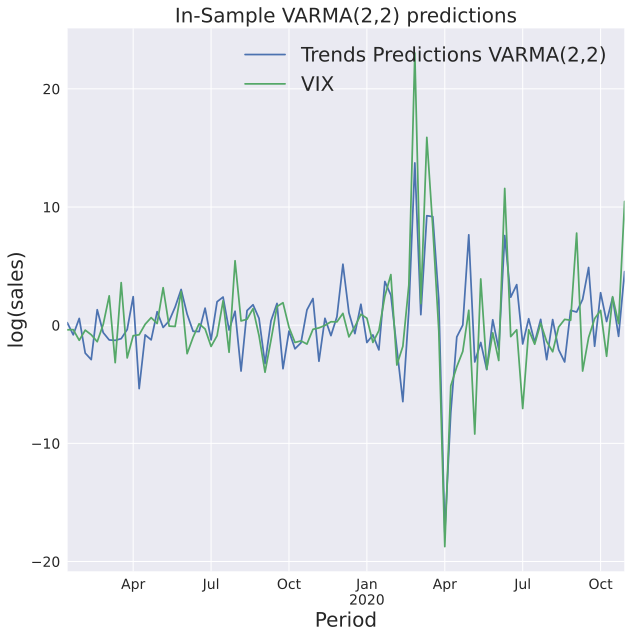

In [25]:
# Plotting the insample prediction of the VARMA(2,2) model
predictions_exo = result_varma.fittedvalues["VIX"]
df_vix["Trends Predictions VARMA(2,2)"] = predictions_exo
axes = df_vix[["Trends Predictions VARMA(2,2)", "VIX"]].plot(figsize=(10, 10))
_ = axes.set_xlabel("Period", fontsize=FONT_SIZE)
_ = axes.set_ylabel("log(sales)", fontsize=FONT_SIZE)
_ = axes.set_title("In-Sample VARMA(2,2) predictions", fontsize=FONT_SIZE)
_ = axes.legend(fontsize=FONT_SIZE)

In [26]:
# Computing mean absolute error of the log differences
error_arma = np.mean(np.abs(df_vix["Baseline Predictions"] - df_vix["VIX"]))
error_var = np.mean(np.abs(df_vix["Trends Predictions VAR(3)"] - df_vix["VIX"]))
error_varma = np.mean(np.abs(df_vix["Trends Predictions VARMA(2,2)"] - df_vix["VIX"]))

print(f"Error of the ARMA(2,2) model: {error_arma:.2f}%")
print(f"Error of the VAR(3) model: {error_var:.2f}%")
print(f"Error of the VARMA(2,2) model: {error_varma:.2f}%")

Error of the ARMA(2,2) model: 2.70%
Error of the VAR(3) model: 2.44%
Error of the VARMA(2,2) model: 2.30%


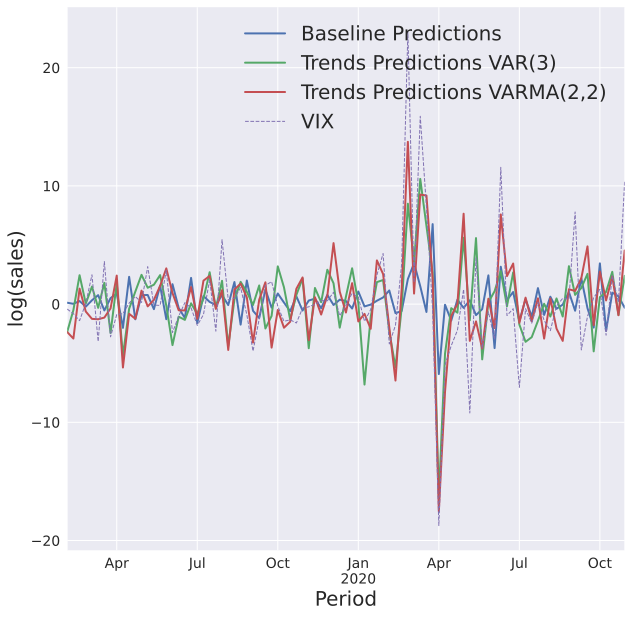

In [27]:
# let's plot all of the predictions on one figure
df_vix.dropna(inplace=True)
axes = df_vix[
    [
        "Baseline Predictions",
        "Trends Predictions VAR(3)",
        "Trends Predictions VARMA(2,2)",
    ]
].plot(figsize=(10, 10), linewidth=2)
df_vix["VIX"].plot(linewidth=1, style="--", legend=True)
_ = axes.set_xlabel("Period", fontsize=FONT_SIZE)
_ = axes.set_ylabel("log(sales)", fontsize=FONT_SIZE)
_ = axes.legend(fontsize=FONT_SIZE)

using VAR(3) and VARMA(2,2) with google trends seems to react better especially in big jumps, but we are doing predictions insample!
Let us roll the model as an outsample prediction for the 3 models developped:
- baseline: ARMA(2,2)
- Trends model 1: VAR(3)
- Trends model 2: VARMA(2,2)

## Rolling models

In [29]:
import warnings

warnings.filterwarnings("ignore")
start_rolling = 40
window_rolling = 40
# rolling ARMA
pred_list_endo = rolling_ARMA_endo(
    df_vix, start_rolling, window_rolling, order=(2, 0, 2)
)

# rolling VAR
pred_list_exo_var = rolling_VAR_exo(
    df_vix[["VIX"] + keywords],
    start_rolling,
    window_rolling,
    order=3,
    exogenous_regressors=keywords,
)

# rolling VARMA
pred_list_exo_varma = rolling_VARMA_exo(
    df_vix[["VIX"] + keywords],
    start_rolling,
    window_rolling,
    order=(2, 2),
    exogenous_regressors=keywords,
)

In [30]:
# Inserting a dummy column for the prediction in the dataframe
df_vix["Outsample Baseline Predictions"] = np.nan
df_vix.iloc[start_rolling : len(df_vix)][
    "Outsample Baseline Predictions"
] = pred_list_endo[0]

df_vix["Outsample Trends Predictions VAR(3)"] = np.nan
df_vix.iloc[start_rolling : len(df_vix)][
    "Outsample Trends Predictions VAR(3)"
] = pred_list_exo_var[0]

df_vix["Outsample Trends Predictions VARMA(2,2)"] = np.nan
df_vix.iloc[start_rolling : len(df_vix)][
    "Outsample Trends Predictions VARMA(2,2)"
] = pred_list_exo_varma[0]

In [32]:
from sklearn.metrics import mean_absolute_error

df_final = df_vix.copy()
df_final.dropna(inplace=True)
baseline_mae = mean_absolute_error(
    df_final["VIX"], df_final["Outsample Baseline Predictions"]
)
trends_mae_var = mean_absolute_error(
    df_final["VIX"], df_final["Outsample Trends Predictions VAR(3)"]
)
trends_mae_varma = mean_absolute_error(
    df_final["VIX"], df_final["Outsample Trends Predictions VARMA(2,2)"]
)

improvement_var = (baseline_mae - trends_mae_var) / baseline_mae
improvement_varma = (baseline_mae - trends_mae_varma) / baseline_mae


print(f"MAE of the baseline model: {baseline_mae:.2f}")
print(f"MAE of the trends model VAR: {trends_mae_var:.2f}")
print(f"MAE of the trends model VARMA: {trends_mae_varma:.2f}")

print(f"MAE improvement VAR : {100*improvement_var:.2f}%")
print(f"MAE improvement VARMA : {100*improvement_varma:.2f}%")

MAE of the baseline model: 4.01
MAE of the trends model VAR: 8.03
MAE of the trends model VARMA: 5.58
MAE improvement VAR : -100.08%
MAE improvement VARMA : -39.12%


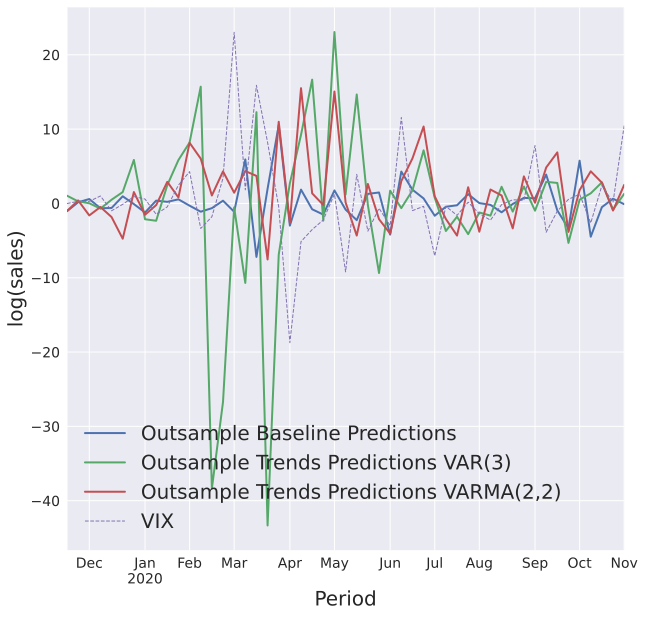

In [33]:
df_vix.dropna(inplace=True)
axes = df_final[
    [
        "Outsample Baseline Predictions",
        "Outsample Trends Predictions VAR(3)",
        "Outsample Trends Predictions VARMA(2,2)",
    ]
].plot(figsize=(10, 10), linewidth=2)
df_final["VIX"].plot(linewidth=1, style="--", legend=True)
_ = axes.set_xlabel("Period", fontsize=FONT_SIZE)
_ = axes.set_ylabel("log(sales)", fontsize=FONT_SIZE)
_ = axes.legend(fontsize=FONT_SIZE)

## Conclusion

We can see that adding google trends results to lower the performance of outsample predictions. Our hypothesis is that the market contains much more information and reacts way before people start looking for keywords. This shows how hard it is to predict financial markets. Several theories around market efficiency focus on the fact that the market data contains all available information. We are also aware that this data is available live in a high frequency and we imagine if there is any opportunity, big institutions will exploit it and make it disappear especially when using data as accessible as google trends to make predictions.